In [1]:
import os
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
import numpy as np
import random
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv ## vectorization
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

np.random.seed(3)
n_features = 4 # n, m, v, tvar
fineness = 200

In [2]:
def get_data(NumPh = 500, clm_rate = 0.3, clm_shape = 2, clm_scale = 100):
    
    clm_freq = np.random.binomial(n=1,p=clm_rate,size = NumPh)
    clm_sev = np.random.gamma(shape = clm_shape, scale = clm_scale, size = NumPh)
    return clm_freq*clm_sev

def tvar(l,p):
    n = int(p*len(l))
    return sum(l[n:]) / (len(l) - n)

def get_state(l):
    
    l = np.hstack(l)
    return [l.size, np.mean(l), np.std(l), tvar(sorted(list(l)),0.95)]

[500, 56.56242612066192, 115.66292792264318, 433.76381988712035]

In [3]:
def npbuhl(man_rate, D): ## r x t matrix of data
    D = np.array(D)
    n = D.shape[0]
    r = D.shape[1]
    M = np.array([np.mean(D,axis=0) for i in range(n)])
    v = np.sum(np.square(D - M)) / (r*n)
    a = np.sum(np.square(np.mean(D,axis=0) - np.mean(D))) / (r-1) - v / n
    k = v/a
    if a < 0:
        Z = 0
        return 0
    else:
        Z = n / (n + k)

    return Z*D.mean() + (1 - Z)*man_rate

def amer(thresh,D,man_rate):
    D = np.array(D)
    Z = np.sqrt(len(D) / thresh)
    return Z*D.mean() + (1-Z)*man_rate

In [4]:
class CredibilityEnv(Env):
    def __init__(self):
        self.action_space = Discrete(201)
        self.observation_space = Box(low=0, high=np.inf, shape=(n_features,), dtype=np.float32)
        
        self.time_step = 0
        self.T = np.random.geometric(1/12)
        self.data = [get_data()]
        self.state = np.array(get_state(self.data))
        
        self.manual_mean = np.random.normal(loc=150,scale=5,size=self.T)
        
        self.american_thresh = 10000
        
        self.american_preds = []
        self.american_err = 0
        
        self.npbuhl_preds = []
        self.npbuhl_err = 0
        
    def set_amer_thresh(self,t):
        self.amer_thresh = t
    
    def reset(self,seed=None):
        self.T = np.random.geometric(1/12)
        self.time_step = 0
        self.manual_mean = np.random.normal(loc=150,scale=5,size=self.T)
        
        self.data = [get_data()]
        
        self.state = np.array(get_state(self.data))
        
        self.american_preds = []
        self.american_err = 0

        self.npbuhl_preds = []
        self.npbuhl_err = 0
        return self.state,{}

    def step(self, action):
        
        self.test_data = list(get_data())
        
        reward = self.calculate_reward(action)

        self.data = np.vstack([self.data,self.test_data])
        self.state = np.array(get_state(self.data))
        
        amer_pred = amer(self.american_thresh, self.data,self.manual_mean[self.time_step])
        npbuhl_pred = npbuhl(self.manual_mean[self.time_step],self.data)
        self.american_preds.append(amer_pred)
        self.npbuhl_preds.append(npbuhl_pred)
        self.american_err += abs(amer_pred - np.mean(self.test_data))
        self.npbuhl_err += abs(npbuhl_pred - np.mean(self.test_data))
        
        self.time_step += 1
        
        terminated = self.time_step >= self.T
        
        truncated = terminated  # Assuming no truncation other than natural episode termination
        info = {}  # You can put any additional information here
        
        
        
        return self.state, reward, terminated, truncated, info

    def calculate_reward(self, action): # normal rv represents mean of large dataset
        self.model_prediction_pp = action/fineness * self.state[1] + (1 - action/fineness) * self.manual_mean[self.time_step]
        err = -abs(self.model_prediction_pp - np.mean(self.test_data))
        return err

In [5]:
# Initialize environment
env = CredibilityEnv()
# Initialize model
model = DQN("MlpPolicy", env, verbose=1, exploration_initial_eps=1.0, exploration_final_eps=0.01, exploration_fraction=0.8, learning_rate=0.005,gamma=0.8)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
#cred_path = os.path.join('Training', 'Saved Models', 'Cred_Model_PPO')
env = CredibilityEnv()
model = PPO("MlpPolicy", env, verbose=1)
stop_callback = StopTrainingOnRewardThreshold(reward_threshold = -24, verbose=1)
eval_callback = EvalCallback(env,
                             callback_on_new_best = stop_callback,
                             eval_freq=10000,
                             best_model_save_path = "cmdqn4f.zip",
                             verbose=1)

(array([0.32111177, 1.1463145 , 1.791344  , 0.0083853 ], dtype=float32),
 83,
 (array([500.        ,  51.96174032, 114.88104409, 434.35909504]), {}),
 (array([1000.        ,   54.77797634,  115.02212511,  425.38616665]),
  -90.22442199110154,
  False,
  False,
  {}))

In [7]:
model.learn(total_timesteps=500000,callback=eval_callback)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | -522     |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1154     |
|    time_elapsed     | 0        |
|    total_timesteps  | 45       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.6     |
|    ep_rew_mean      | -898     |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 760      |
|    time_elapsed     | 0        |
|    total_timesteps  | 157      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.1     |
|    ep_rew_mean      | -791     |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes       

C:\Users\acriisdu\AppData\Roaming\Python\Python310\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | -560     |
|    exploration_rate | 0.975    |
| time/               |          |
|    episodes         | 880      |
|    fps              | 674      |
|    time_elapsed     | 14       |
|    total_timesteps  | 10068    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | -556     |
|    exploration_rate | 0.975    |
| time/               |          |
|    episodes         | 884      |
|    fps              | 670      |
|    time_elapsed     | 15       |
|    total_timesteps  | 10125    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.9     |
|    ep_rew_mean      | -572     |
|    exploration_rate | 0.975    |
| time/               |          |
|    episodes       

In [37]:
obs_list = []
actions_list = []
manual_rates = []
err_model = []
err_amer = []
err_buhl = []
# Reset the environment
obs = env.reset()[0]

# Run the environment for one episode
for t in range(env.T):
    action = model.predict(obs)[0]
    obs, reward, done, info, x = env.step(action)
    #manual_rates.append(info["mean"])
    # Log the observation and action
    obs_list.append(obs)
    err_model.append(reward)
    err_amer.append(env.american_err)
    err_buhl.append(env.npbuhl_err)
    actions_list.append(env.model_prediction_pp)
# Convert lists to NumPy arrays for easier manipulation
obs_array = np.array(obs_list)
actions_array = np.array(actions_list)
manual_rates = np.array(env.manual_mean)
SQRT = np.array(env.american_preds)
BUHL = np.array(env.npbuhl_preds)

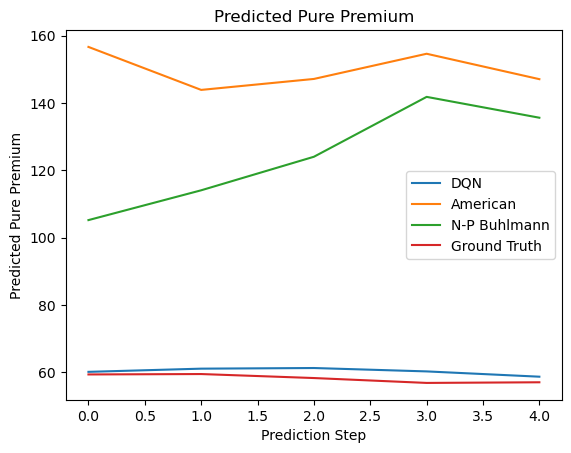

In [38]:
import matplotlib.pyplot as plt
# for i in range(n_features):
#     plt.figure(i)
#     plt.plot(np.array(obs_list).T[i])#, actions_list)#,alpha=0.1)
#     plt.show()
plt.plot(actions_list)
plt.plot(SQRT)
plt.plot(BUHL)
plt.plot(obs_array.T[1])
plt.legend(["DQN","American","N-P Buhlmann","Ground Truth"])
plt.title("Predicted Pure Premium")
plt.xlabel("Prediction Step")
plt.ylabel("Predicted Pure Premium")
plt.show()

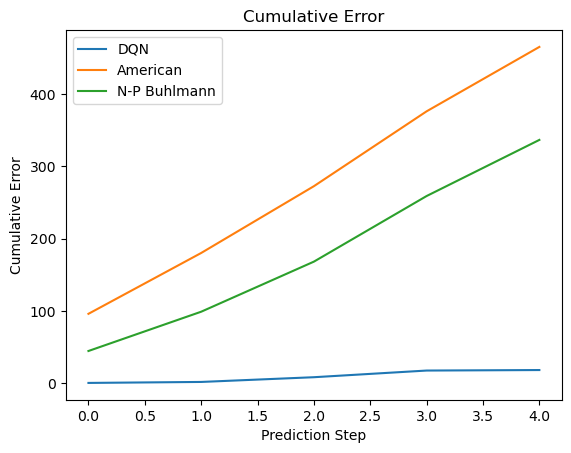

In [39]:
plt.plot(-np.cumsum(err_model))
plt.plot(err_amer)
plt.plot(err_buhl)
plt.legend(["DQN","American","N-P Buhlmann"])
plt.title("Cumulative Error")
plt.xlabel("Prediction Step")
plt.ylabel("Cumulative Error")
plt.show()

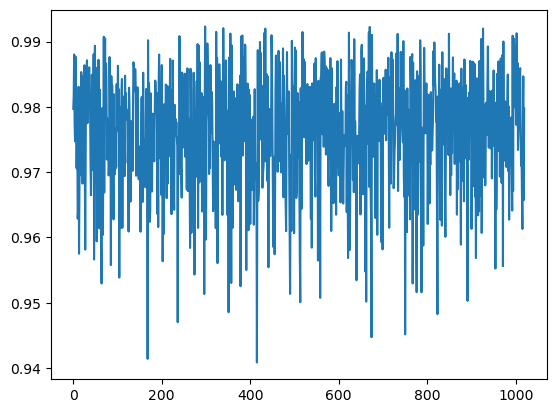

In [15]:
M = 100
mi = 40
ma = 50000
step = int((ma - mi) / 1000)
AMIMPR = [0 for step in range(mi,ma,step)]
for T in range(mi,ma,step):
    env.set_amer_thresh(T)
    for m in range(M):
        err_model = []
        err_amer = []
        # Reset the environment
        obs = env.reset()[0]
        # Run the environment for one episode
        for t in range(env.T):
            action = model.predict(obs)[0]
            obs, reward, done, info, x = env.step(action)
            #manual_rates.append(info["mean"])
            # Log the observation and action
            obs_list.append(obs)
            
            err_model.append(pow(reward,2))
            err_amer.append(pow(env.american_err,2))
        AMIMPR[T // step - mi // step] += (1 - sum(err_model)/sum(err_amer)) / M
plt.plot(AMIMPR)

In [17]:
obs_list = []
actions_list = []
manual_rates = []
# Reset the environment
obs = env.reset()[0]

# Run the environment for one episode
for t in range(env.T):
    action = model.predict(obs)[0]
    obs, reward, done, info, x = env.step(action)
    #manual_rates.append(info["mean"])
    # Log the observation and action
    obs_list.append(obs)
    actions_list.append(action)

# Convert lists to NumPy arrays for easier manipulation
obs_array = np.array(obs_list)
actions_array = np.array(actions_list)
manual_rates = np.array(env.manual_mean)

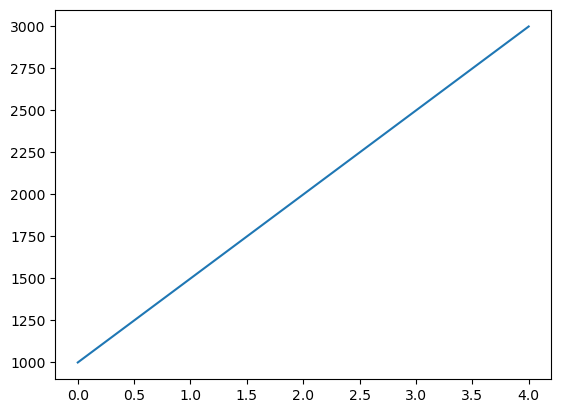

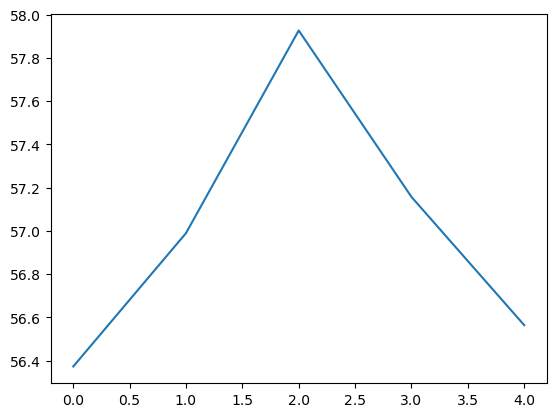

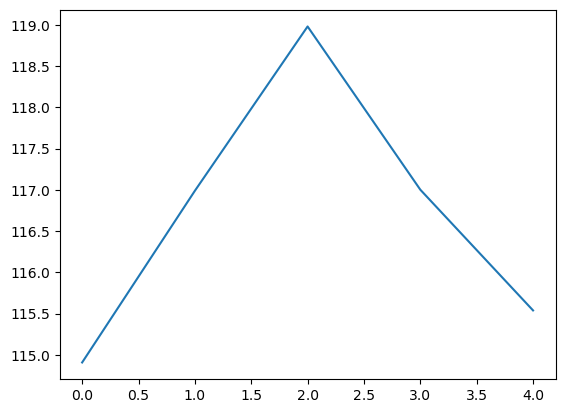

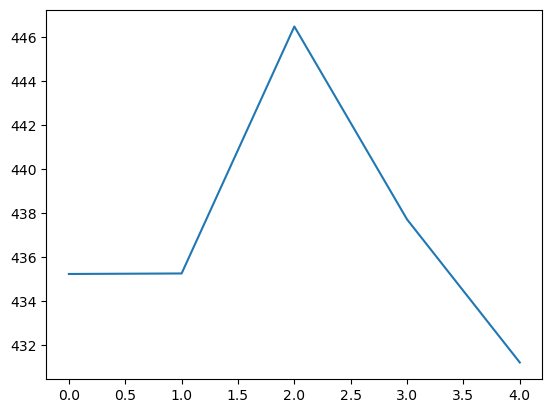

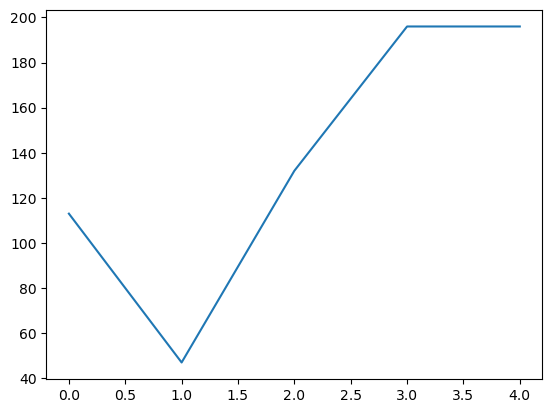

In [18]:
import matplotlib.pyplot as plt
for i in range(n_features):
    plt.figure(i)
    plt.plot(np.array(obs_list).T[i])#, actions_list)#,alpha=0.1)
    plt.show()
plt.plot(actions_list)

In [19]:
obs_list = []
actions_list = []
manual_rates = []
# Reset the environment
obs = env.reset()[0]

# Run the environment for one episode
for t in range(env.T):
    action = model.predict(obs)[0]
    obs, reward, done, info, x = env.step(action)
    #manual_rates.append(info["mean"])
    # Log the observation and action
    obs_list.append(obs)
    actions_list.append(action)

# Convert lists to NumPy arrays for easier manipulation
obs_array = np.array(obs_list)
actions_array = np.array(actions_list)
manual_rates = np.array(env.manual_mean)

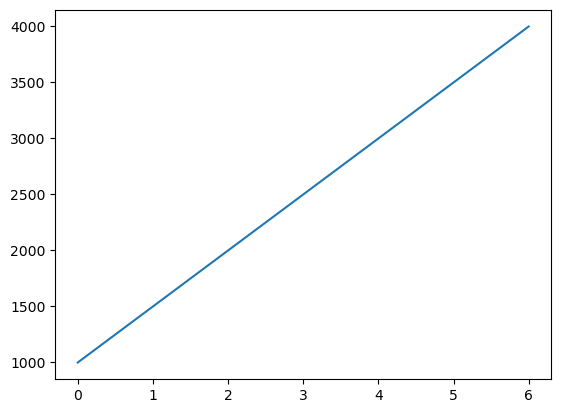

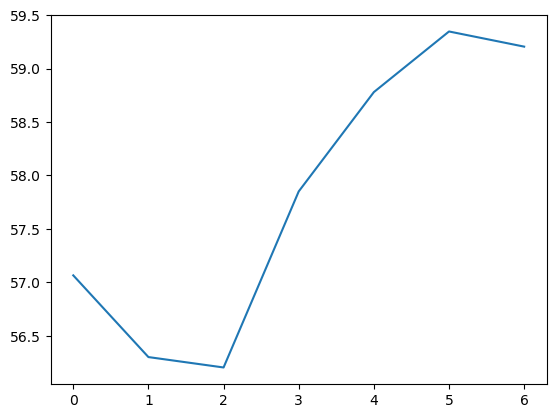

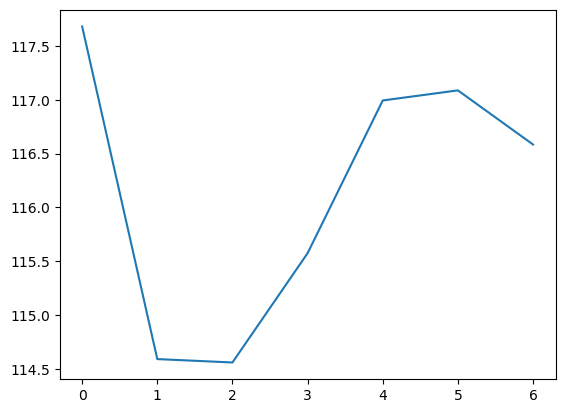

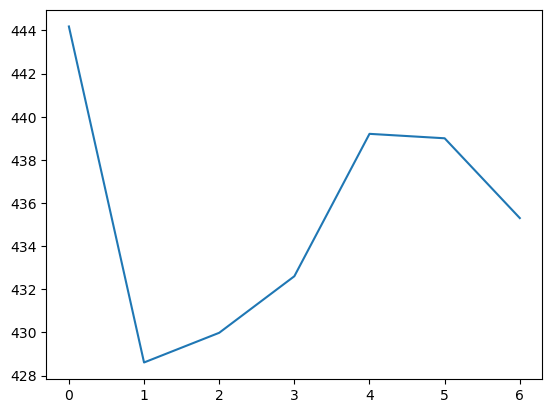

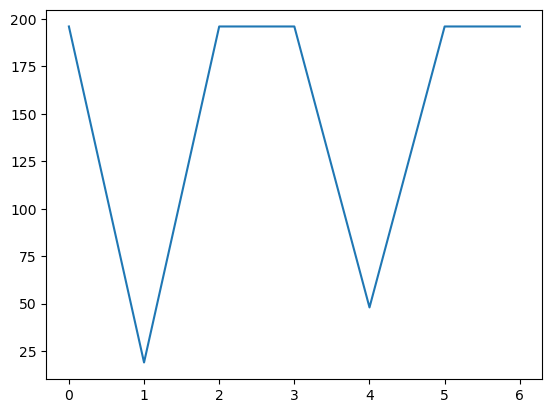

In [20]:
import matplotlib.pyplot as plt
for i in range(n_features):
    plt.figure(i)
    plt.plot(np.array(obs_list).T[i])#, actions_list)#,alpha=0.1)
    plt.show()
plt.plot(actions_list)